# Проект для компании «Чётенькое такси»

## Подготовка

Подключаем необходимые библиотеки

In [124]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Импортируем предоставленные данные методом read_csv() в переменную df, выводим общую информацию методом info(), выведем первые 5 строк датафреймов методом head()

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выведем общую информацию о данных методом describe()

In [3]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Выполним ресемплирование по одному часу с помощью метода resample()

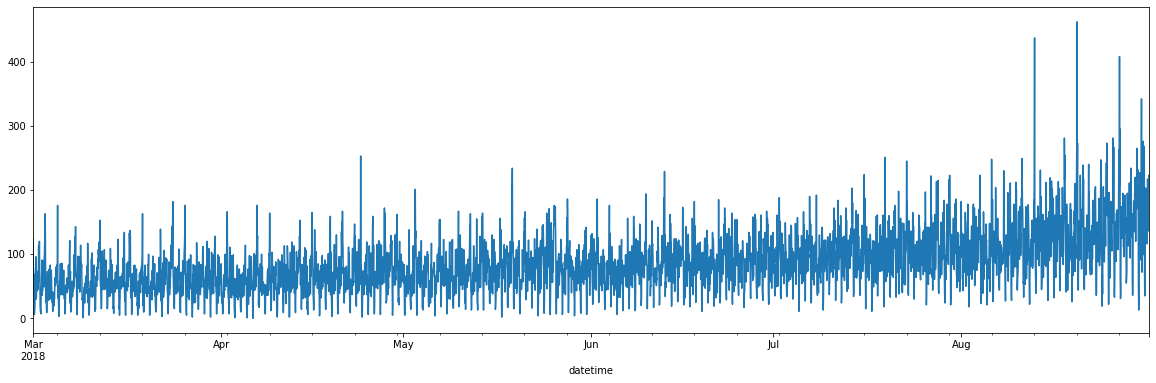

In [4]:
df = df.resample('1H').sum()
plt.figure(figsize = (20, 6))
df['num_orders'].plot()

Извлечем дополнительные признаки из столбца datetime и запишем их в новые столбцы

In [5]:
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

In [6]:
make_features(df)
df.head()

,num_orders,year,month,day,dayofweek
datetime,,,,,
2018-03-01 00:00:00,124,2018,3,1,3
2018-03-01 01:00:00,85,2018,3,1,3
2018-03-01 02:00:00,71,2018,3,1,3
2018-03-01 03:00:00,66,2018,3,1,3
2018-03-01 04:00:00,43,2018,3,1,3


### Вывод

Данные были импортированны методом read_csv() с параметрами index_col = [0], parse_dates = [0] в датафрейм df, по результатам работы методом info() и describe() можно сделать следующие выводы:

- одинаковое колличество строк свидетельствует об отсутствии дубликатов и пропусков
- предположение выше подтверждает результат работы метода describe()
- извлечем дополнительные признаки из столбца datetime и запишем их в новые столбцы
- ресемплируем данные по одному часу с помощью метода resample()

Таким образом можно заключить, что данные адекватны и не требуют подготовки к дальнейшему анализу

## Анализ

Выполним проверку того, находятся ли данные в хронологическом порядке с помощью метода is_monotonic()

In [7]:
df.sort_index(inplace = True)
print(df.index.is_monotonic)

True


Выведем график тренда, найденного с помощью метода seasonal_decompose()

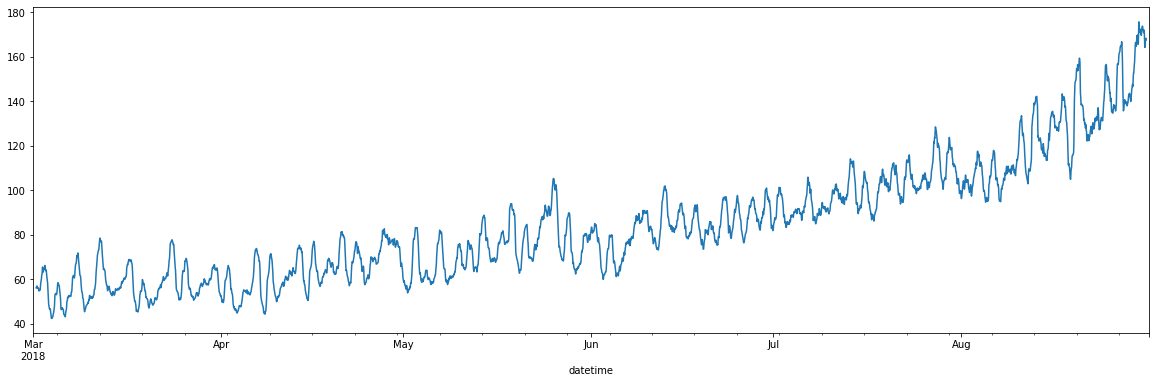

In [8]:
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize = (20, 6))
decomposed.trend.plot(ax = plt.gca())

Выведем график сезонности

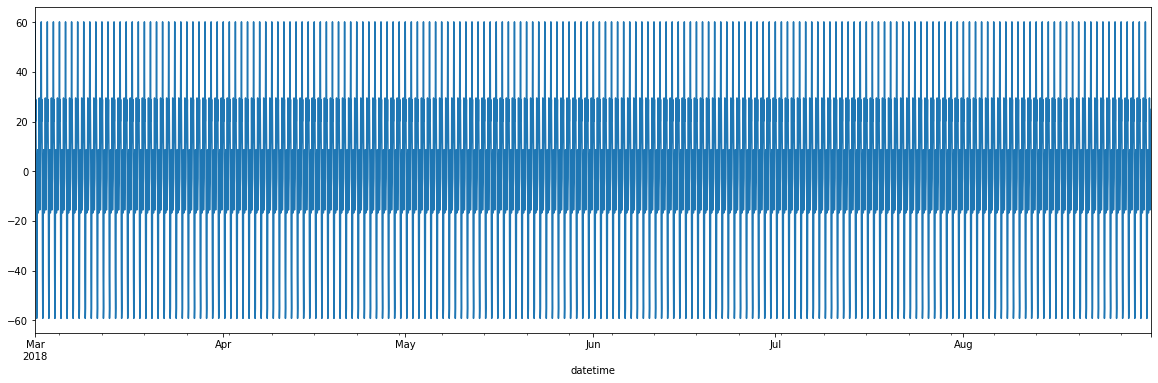

In [9]:
plt.figure(figsize = (20, 6))
decomposed.seasonal.plot(ax = plt.gca())

Выводем график остатков

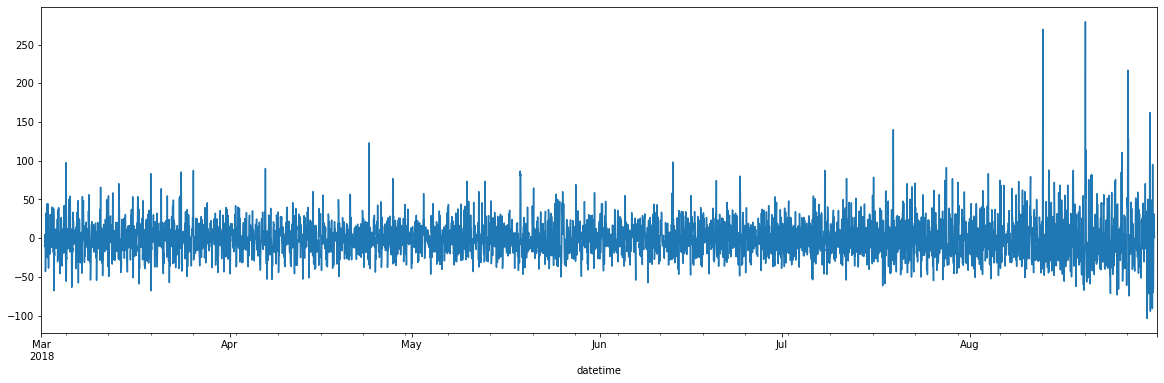

In [10]:
plt.figure(figsize = (20, 6))
decomposed.resid.plot(ax = plt.gca())

### Вывод

Данные были проанализорованны следующим образом:

- была произведена проверка столбца datetime на соответствие хронологическому порядку; в результате проверки была выявленна хронология
- был выведен график тренда, найденного с помощью метода seasonal_decompose(), по которому можно заключить, что колличество заказов такси уверенно увеличивается
- график сезонности стационарен

## Обучение

Рассмотрим разное колличество сдвигов и средних и по критерию Пирсона отберем 10 самых важных

In [166]:
df_temp = df

for lag in range(1, 30 + 1):
    df_temp['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
for size in range (1, 30 + 1):
    df_temp['rolling_{}'.format(size)] = df['num_orders'].shift().rolling(size).mean()

matrix = df_temp.corr().values
matrix[0, 1] = 0
matrix[0, 0] = 0
corr_list = matrix[0, :]
corr_list = np.array(corr_list.tolist())
ind = np.argpartition(corr_list, -10)[-10:].tolist()
begin_list = [0]
ind.extend(begin_list)
print(ind)

[37, 27, 62, 36, 60, 61, 59, 5, 28, 35, 0]


In [167]:
df_new = df_temp.iloc[:, ind]
df_new = df_new.dropna()
df_new

,rolling_3,lag_23,rolling_28,rolling_2,rolling_26,rolling_27,rolling_25,lag_1,lag_24,rolling_1,num_orders
datetime,,,,,,,,,,,
2018-03-02 04:00:00,86.333333,6.0,61.178571,69.5,57.846154,58.851852,57.32,64.0,43.0,64.0,20
2018-03-02 05:00:00,53.000000,12.0,57.464286,42.0,55.884615,56.444444,55.48,20.0,6.0,20.0,11
2018-03-02 06:00:00,31.666667,15.0,54.821429,15.5,53.769231,54.222222,54.20,11.0,12.0,11.0,11
2018-03-02 07:00:00,14.000000,34.0,52.678571,11.0,52.538462,52.185185,54.40,11.0,15.0,11.0,7
2018-03-02 08:00:00,9.666667,69.0,50.571429,9.0,52.576923,50.851852,54.20,7.0,34.0,7.0,46
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,207.000000,142.0,174.500000,212.0,172.153846,175.185185,165.36,207.0,72.0,207.0,136
2018-08-31 20:00:00,186.666667,198.0,173.785714,171.5,164.230769,170.814815,163.72,136.0,142.0,136.0,154
2018-08-31 21:00:00,165.666667,158.0,170.214286,145.0,163.346154,163.851852,167.00,154.0,198.0,154.0,159


In [168]:
train, temp = train_test_split(df_new, shuffle = False, test_size = 0.2)
valid, test = train_test_split(temp, shuffle = False, test_size = 0.5)

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']

Рассмотрим гиперпараметры разных моделей

In [169]:
# дерево решений
best_result = 100
for depth in range(1, 11):
    model = DecisionTreeRegressor(max_depth = depth, random_state = 12345)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    result = mean_squared_error(predicted, target_valid) ** 0.5
    if result < best_result:
        best_depth = depth
        best_result = result
        
print('DecisionTreeRegressor')
print('Best RMSE:', best_result)
print('Best depth:', best_depth)

DecisionTreeRegressor
Best RMSE: 37.90151859433523
Best depth: 7


In [170]:
# случайный лес
best_result = 100
for est in range(10, 100, 5):
    for depth in range(1, 20):
        model = RandomForestRegressor(random_state = 12345, n_estimators = est, max_depth = depth)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        result = mean_squared_error(predicted, target_valid) ** 0.5
        if result < best_result:
            best_result = result
            best_est = est
            best_depth = depth

print('RandomForestRegressor')
print('Best RMSE:', best_result)
print('Best depth:', best_depth)
print('Best est:', best_est)

RandomForestRegressor
Best RMSE: 36.839602563647524
Best depth: 17
Best est: 95


### Вывод

В результате исследования были получены следующие результаты:

- DecisionTreeRegressor:
    - Best RMSE: 37.90151859433523
    - Best depth: 7
    
- RandomForestRegressor:
    - Best RMSE: 36.839602563647524
    - Best depth: 17
    - Best est: 95
    
По полученым резульатам можно сделать вывод, что обе модели показывают достаточно хорошее качество предстаканий, но лучшей показала себя RandomForestRegressor

## Тестирование

Проанализируем модели с лучшими гоперпараметрами на тестовой выборке

In [174]:
train, test = train_test_split(df_new, shuffle = False, test_size = 0.1)

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

In [175]:
# дерево решений
model = DecisionTreeRegressor(max_depth = 7, random_state = 12345)
model.fit(features_train, target_train)
predicted = model.predict(features_test)
result = mean_squared_error(predicted, target_test) ** 0.5

print('DecisionTreeRegressor')
print('RMSE:', result)

DecisionTreeRegressor
RMSE: 60.258863510218426


In [177]:
# случайный лес
model = RandomForestRegressor(random_state = 12345, n_estimators = 95, max_depth = 17)
model.fit(features_train, target_train)
predicted = model.predict(features_test)
result = mean_squared_error(predicted, target_test) ** 0.5

print('RandomForestRegressor')
print('RMSE:', result)

RandomForestRegressor
RMSE: 47.55874465981923


### Вывод

Были проанализированны модели с лучшими гиперпараметрами на тестовой выборке, были получины следующие результаты:

- DecisionTreeRegressor:
    - RMSE: 60.258863510218426
    
- RandomForestRegressor:
    - RMSE: 47.55874465981923
    
Как и ожидалось, модель RandomForestRegressor показала лучшие рещультаты из рассмотренных моделей на найденных гиперпараметрах, порог в RMSE = 48 был пройден

## Вывод

Цель проекта:  привлекать больше водителей в период пиковой нагрузки.
Задача: спрогнозировать количество заказов такси на следующий час, построить модель для такого предсказания.

Работа над проектом была выполненна в несколько этапов:

**1 Подготовка**

Данные были импортированны методом read_csv() с параметрами index_col = [0], parse_dates = [0] в датафрейм df, по результатам работы методом info() и describe() можно сделать следующие выводы:

- одинаковое колличество строк свидетельствует об отсутствии дубликатов и пропусков
- предположение выше подтверждает результат работы метода describe()
- извлечем дополнительные признаки из столбца datetime и запишем их в новые столбцы
- ресемплируем данные по одному часу с помощью метода resample()

Таким образом можно заключить, что данные адекватны и не требуют подготовки к дальнейшему анализу

**2 Анализ**

Данные были проанализорованны следующим образом:

- была произведена проверка столбца datetime на соответствие хронологическому порядку; в результате проверки была выявленна хронология
- был выведен график тренда, найденного с помощью метода seasonal_decompose(), по которому можно заключить, что колличество заказов такси уверенно увеличивается

**3 Обучение**

В результате исследования были получены следующие результаты:

- DecisionTreeRegressor:
    - Best RMSE: 37.90151859433523
    - Best depth: 7
    
- RandomForestRegressor:
    - Best RMSE: 36.839602563647524
    - Best depth: 17
    - Best est: 95
    
По полученым резульатам можно сделать вывод, что обе модели показывают достаточно хорошее качество предстаканий, но лучшей показала себя RandomForestRegressor

**4 Тестирование**

Были проанализированны модели с лучшими гиперпараметрами на тестовой выборке, были получины следующие результаты:

- DecisionTreeRegressor:
    - RMSE: 60.258863510218426
    
- RandomForestRegressor:
    - RMSE: 47.55874465981923
    
Как и ожидалось, модель RandomForestRegressor показала лучшие рещультаты из рассмотренных моделей на найденных гиперпараметрах, порог в RMSE = 48 был пройден

Можно заключить, что наиболее подходящей является модель RandomForestRegressor.

Таким образом задача проекта была выполненна, а цель достигнута.